In [194]:
import pandas as pd
import datetime
import nltk
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
from matplotlib.gridspec import GridSpec

%matplotlib inline

### Reading In Data Using SQLite

In [24]:
import sqlite3
conn = sqlite3.connect('database.sqlite')

In [25]:
artist = pd.read_sql_query('select * from artists', conn)
content = pd.read_sql_query('select * from content', conn)
genres = pd.read_sql_query('select * from genres', conn)
reviews = pd.read_sql_query('select * from reviews', conn)
years = pd.read_sql_query('select * from years', conn)
labels = pd.read_sql_query('select * from labels', conn)

In [26]:
pitchfork_df = pd.merge(content,reviews, on='reviewid')
pitchfork_df = pd.merge(pitchfork_df, years, on='reviewid')
pitchfork_df = pd.merge(pitchfork_df, genres, on='reviewid')

In [27]:
pitchfork_df.drop(['author_type'],inplace=True,axis=1)

In [28]:
p4k = pitchfork_df.drop(pitchfork_df[pitchfork_df.content == ''].index)

In [29]:
p4k = p4k.reset_index().drop('index',axis=1)

In [90]:
len(p4k)

23619

In [92]:
p4k = p4k.drop_duplicates('reviewid')

In [93]:
len(p4k)

18379

In [100]:
p4k = p4k.reset_index()

In [102]:
p4k = p4k.drop('index', axis=1)

### Exploratory Data Analysis

[Text(0,0.5,'Frequency'),
 Text(0.5,0,'Word Count'),
 Text(0.5,1,'Distribution of Review Length on Pitchfork')]

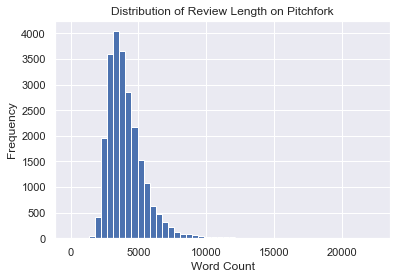

In [30]:
review_length = p4k.content.str.len()
sns.set()
ax = review_length.hist(bins=50)
ax.set(xlabel='Word Count', ylabel='Frequency',
      title='Distribution of Review Length on Pitchfork')

In [465]:
np.sum(list(review_length))

96556405

### Taking a Sample of the Data In Order to Conduct Preliminary Modeling

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
restof_df, sample_df = train_test_split(p4k, test_size=0.20, 
                                        random_state=666)

In [34]:
sample_df = sample_df.reset_index()
sample_df.drop(['index'],axis=1,inplace=True)

### NLP Modeling

In [98]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.decomposition import NMF

#Tokenizer function 
def custom_tokenizer(text):
    
    remove_punct = str.maketrans('', '', string.punctuation)
    text = text.translate(remove_punct).replace('" "','').replace('“','').replace("''",'').replace("’",'').replace('“ ”','').replace('” ','')
    
    remove_digits = str.maketrans('', '', string.digits)
    text = text.lower().translate(remove_digits)
    
    tokens = word_tokenize(text)
    
    stop_words = stopwords.words('english')
    tokens_stop = [y for y in tokens if y not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    tokens_lemma = [lemmatizer.lemmatize(y) for y in tokens_stop]
    
    # Custom stop words chosen based on results
    custom_stop_words = ['there', 'theyre', 'theyve', 'good', 'lot', 'kind', 'bit', 'that',
                         'enough', 'theyv', 'pretty', 'sound', 'like',
                        'feel', 'like', 'collabor', 'project', 'moment', 'solo', 'producer',
                         'made', 'decade', 'might', 'hard', 'rather', 'collaboration', 
                         'trying', 'energy', 'sings', 'vision', 'clear', 'within', 'career',
                         'cut', 'idea', 'star', 'since', 'towards', 'mean', 'duo', 'across',
                        'im', 'think', 'youre', 'guy', 'really', 'people', 'going', 
                         'got', 'ive', 'want', 'maybe', 
                        'name', 'working', 'form', 'someone', 'felt', 
                         'personal', 'interview', 'suggests', 'future', 'become', 
                         'u', 'day', 'least', 'cant', 'probably',
                         'ever', 'man', 'kid', 'right', 'sort', 'need',
                        'recording', 'early', 'recorded', 'tape', 'released', 'four', 'three', 'five',
                        'sometimes', 'ep', 'fulllength', 'last', 'year','lp', 
                        'nothing','actually','stuff','better', 'anything', 'let', 
                        'isnt','bad','hear','great','sure', 'didnt', 'play', 'start', 'whole', 'everything',
                        'word', 'see', 'place', 'put', 'look', 'tell', 'mind', 'said', 'away',
                        'far', 'may', 'keep',  'set', 'collection', 'making', 'simple', 'free', 'instead', 'move',
                        'artist', 'label', 'style', 'musical', 'whose', 'art', 'genre', 
                         'recent', 'musician', 'scene', 'act',  'free', 'instead', 'move', 
                         'version', 'original', 'disc', 'material', 'single', 'mix', 'different', 'classic', 'later', 
                        'john', 'turn', 'fact','seem', 'easy' ,'quite', 'course', 
                        'face', 'perhaps', 'hand', 'next', 'half', 'give', 'group', 'member', 'however', 'listener', 'guitarist', 
                         'former', 'side', 'drummer', 'studio', 'singer', 'number',
                        'big', 'hit', 'fan', 'past', 'old' ] 

    tokens_final = [y for y in tokens_lemma if y not in custom_stop_words]
    
    return tokens_final

In [273]:
def topics(model, feature_names, n_top_words):
    for topic_id, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_id
        message += " ".join([feature_names[i] \
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

In [95]:
def tfidf_nmf(data, n_components, min_df, max_df):
# A function that takes in a dataframe, performs TFIDF vectorization and returns topic models using 
# Non-Negative Matrix Factorization

    tfidf = TfidfVectorizer(tokenizer=custom_tokenizer,
                            ngram_range=(1,2), 
                            min_df=min_df, max_df=max_df)
    
    tfidf.fit(data)
    c = tfidf.transform(data)
    nmf = NMF(n_components=n_components)
    nmf_vecs = nmf.fit_transform(c)
    
    topic_lists = topics(nmf, tfidf.get_feature_names(), 11)
    
    print(topic_lists)
   
    return topic_lists, nmf, nmf_vecs

In [96]:
sample_topic_lists, sample_nmf, sample_nmf_vecs = tfidf_nmf(sample_df.content, 15, 0.08, 0.28)

In [103]:
topic_lists, nmf, nmf_vecs = tfidf_nmf(p4k.content,15, 0.08, 0.28)

Topic #0: indie chorus hook production riff verse lead songwriting opener lack tune
Topic #1: rap hiphop verse production sample guest shit dj game street underground
Topic #2: metal death riff heavy vocalist bass noise slow lead section power
Topic #3: piece noise electronic drone ambient tone space loop bass sonic texture
Topic #4: dance house dj club synth bass groove sample party electronic synths
Topic #5: live show performance audience cover stage playing played already radio experience
Topic #6: black white dark key power cover fire heart light eye history
Topic #7: jazz soul funk hiphop horn rhythm groove bass compilation section tune
Topic #8: punk riff wave noise fun dead history played power hell underground
Topic #9: city york new york country street night home wave american underground sonic
Topic #10: shes woman singing girl power ballad heart character chorus emotional feeling
Topic #11: life story death friend night home dream feeling light character god
Topic #12: blue

### Adding Topic Names to the DataFrame for Improved Legibility

In [384]:
topic_names = ['indie/contemporary', 'rap/hiphop', 'metal/heavy guitar', 'experimental electronic',
				'dance/house/synth', 'live/tour', 'dark/soulful', 'jazz/funk', 
				'rock/punk', 'urban/trendy', 'female artist/gender', 'spiritual/emotional/philosophical',
				'folk/country', 'instrumentation', 'love/lust']

In [243]:
nmf_vecs.shape

(18379, 15)

In [1]:
def topic_column(df, nmfvecs):
#Function to add a column with topic names to the dataframe
    topics = []
    for i in range(len(df)):
        index = np.argmax(nmf_vecs[i])
        topics.append(topic_names[index])
    return pd.Series(topics)

In [359]:
p4k['topic'] = topic_column(p4k, nmf_vecs)

### Adding Subtopics

In [2]:
def subtopics(topics):
# Create subtopics for each topic in order to further engage with the data 
    subtopic_vecs = []
    for topic in topics:
        df = p4k[p4k.topic == topic].content
        print(topic)
        topic_lists, sub_nmf, sub_nmf_vecs = tfidf_nmf(df, 3, 0.10, 0.35)
        subtopic_vecs.append(sub_nmf_vecs)
    return subtopic_vecs

In [363]:
subtopic_vecs = subtopics(topic_names)

indie/contemporary
Topic #0: drum minute le riff part many rhythm every end hook without
Topic #1: love heart cover know synths emotional world hook songwriting fire radio
Topic #2: he tune seems around know always often world say beat behind
None
rap/hiphop
Topic #0: mixtape life young guest hook street rapping world money shit always
Topic #1: wayne lil b mixtape mixtapes rapping dj love series money bitch
Topic #2: vocal sample rock drum guitar mc underground band bass lyric dj
None
metal/heavy guitar
Topic #0: bass voice part doom noise little around beat he line go
Topic #1: black metal he room dark blast light doom split point wave influence
Topic #2: hardcore death metal punk thrash vocalist influence live many blood know lead
None
experimental electronic
Topic #0: rock part voice end space note instrument bass world sonic seems
Topic #1: film soundtrack piano composer string theme composition ambient series feature instrumental
Topic #2: pop beat ambient techno synth electronic

In [373]:
subtopic_names = [ 
			['hook', 'love', 'beat/tune'],
			['guest verse/hook', 'love/money', 'sampling/underground'],
			['bass', 'black metal', 'hardcore'],
			['sonic space', 'soundtrack/ambient', 'techno/synth/emotional'],
			['techno', 'indie', 'disco'],
			['rhythm/percussion', 'cover/reissue/compilation', 'concert'],
			['melodic', 'love', 'hiphop'], 
			['hiphop', 'disco', 'jazz'],
			['indie','rhythm/percussion','hardcore'],
			['singer/songwriter', 'rock','r&b'],
			['melodic', 'love', 'hook'],
            ['emotional', 'dreamy','dark'],
			['folk', 'blues', 'country'], 
			['instrumental', 'love', 'indie'],
			['melodic', 'soulful', 'indie']
]

In [377]:
subtopic_vecs[1].shape

(1213, 3)

In [393]:
topic = p4k.iloc[405].topic
key = topic_names.index(topic)
vec = subtopic_vecs[key]
print(vec.shape)

(796, 3)


In [3]:
def subtopic_column(df, vecs_list):
# Adding a subtopic column for each entry in the dataframe
    subtopics = []
    for i in range(len(df)):
        topic = df.iloc[i].topic
        reviewid = df.iloc[i].reviewid
        working_df = p4k[p4k.topic == topic].reset_index()
        
        topic_index = working_df.index[working_df.reviewid == reviewid][0]
        
        key = topic_names.index(topic)
        
        vecs = (subtopic_vecs[key])
        vec_value = np.argmax(vecs[topic_index])
        
        subtopic = subtopic_names[key][vec_value]
            
        subtopics.append(subtopic)
    
    return pd.Series(subtopics)

In [453]:
subtopic = subtopic_column(p4k, subtopic_vecs)

In [455]:
p4k['subtopic'] = subtopic

### Using the Topics/Subtopics to explore the data

In [285]:
topic_review_score = p4k.groupby(['topic'])['score'].mean().sort_values(ascending=False)

In [286]:
topic_review_score

topic
jazz/funk                            7.412627
experimental electronic              7.253882
metal/heavy guitar                   7.159722
dance/house/synth                    7.076905
acoustic                             7.058639
dark/soulful                         7.050000
live/tour                            7.044108
female artist/gender                 7.040788
spiritual/emotional/philosophical    7.035090
indie rock/punk                      7.028894
folk/country                         6.968488
urban/trendy                         6.933565
rap/hiphop                           6.806595
love/lust                            6.769561
pop/contemporary                     6.657468
Name: score, dtype: float64

In [268]:
p4k.topic.value_counts()

spiritual/emotional/philosophical    2599
pop/contemporary                     2109
experimental electronic              1919
acoustic                             1690
dance/house/synth                    1299
rap/hiphop                           1213
love/lust                            1117
folk/country                         1025
live/tour                             959
jazz/funk                             887
female artist/gender                  863
indie rock/punk                       796
metal/heavy guitar                    792
urban/trendy                          575
dark/soulful                          536
Name: topic, dtype: int64

In [4]:
labels = p4k.topic.value_counts().index
counts = p4k.topic.value_counts().values
plt.figure(figsize=(30,15))
the_grid = GridSpec(2, 2)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
plt.subplot(the_grid[0, 1], aspect=1, title='Topics in Pitchfork Reviews')
source_pie = plt.pie(counts, labels=labels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.pie(counts, labels=labels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

NameError: name 'p4k' is not defined

In [ ]:
def top_artists_by_topic(topic):
    d = df[df['topic'] == topic].sort_values('score',ascending=False)
    a = [d.artist.unique()[:5]]
    b = [d.title.unique()[:5]]
    return list(zip(a,b))

### Laying the Groundwork for the Music Recommender

In [5]:
# Filter the pitchfork reviews on albums that they rate as better than average
good_music = p4k[p4k['score'] > (p4k['score'].mean() + 1)]
print(len(good_music) / len(p4k) * 100)

NameError: name 'p4k' is not defined

In [6]:
def rough_artist_recommender(artist, recs):
#initial function to recommend music
    d = p4k[p4k['artist']==artist]['topic']
    topics = list(d[:].unique())
    suggestions = pd.DataFrame(columns=p4k.columns)
    wildcard_picks = []
    for topic in topics:
        good_suggestions = good_music[good_music['topic'] == topic]
        good_suggestions = good_suggestions[good_suggestions['artist'] != artist]
        wildcard_picks += (list(np.random.choice(good_suggestions.artist.unique(),size=50)))
    recs = list(set(np.random.choice(wildcard_picks, size=recs)))

        
    return recs

In [460]:
wonky_artist_recommender('joy division', 5)

['spring heel jack',
 'prince, the revolution',
 'the chemical brothers',
 'orange juice',
 'to live and shave in l.a.']

In [ ]:
mean_scores = df.groupby(['genre']).mean()['score']

In [ ]:
mean_scores

[Text(0,0.5,'Frequency'),
 Text(0.5,0,'Score'),
 Text(0.5,1,'Distribution of Album Scores on Pitchfork')]

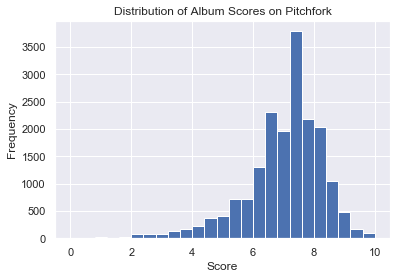

In [196]:
scores = p4k.score
sns.set()
ax = scores.hist(bins=25)
ax.set(xlabel='Score', ylabel='Frequency',
      title='Distribution of Album Scores on Pitchfork')

In [470]:
np.mean(p4k.score)

7.006110234506726

### Sentiment Analysis

In [132]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    print(snt)

In [ ]:
d = df.content.iloc[7110]

In [130]:
def sentiment_analysis(doc):
    sentences = doc.split('.')
    s = []
    for sentence in sentences:
        snt = analyser.polarity_scores(sentence)
        compound_score = snt['compound']
        s.append(compound_score)
    sentiment = (sum(s) / len(s))
    return sentiment           

In [458]:
import pickle
pickle.dump( p4k, open( "pitchfork_data.p", "wb" ) )



In [138]:
sentiment = []
for i in range(len(p4k)):
    s = sentiment_analysis(p4k.content.iloc[i])
    sentiment.append(s)

In [140]:
p4k['sentiment'] = pd.Series(sentiment)

plotting sentiment score against rating score, see if relationship looks strong visually:

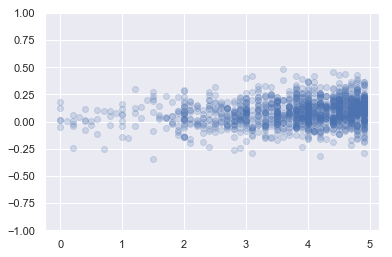

In [364]:
plt.ylim(-1,1)
plt.scatter(p4k[p4k.score < 5].score, p4k[p4k.score<5].sentiment,alpha=0.2)

Unfortunately, seems that there is no relationship between VADER sentiment and Pitchfork Rating

In [161]:
negative = p4k[p4k.sentiment < 0]

In [162]:
negative.score.mean()

6.729995276334437